In [2]:
import os
import numpy as np
import ramanspy as rp
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import cv2
from joblib import Parallel, delayed
from sklearn.cluster import OPTICS
from scipy.signal import find_peaks
import glob
import os

In [5]:
dimensions = {}
for file in glob.glob("Dims_txt/*"): #dimensionları kaydettiğin dosya yolunu yaz. 
    #dimensionları ve datayı farklı klasörlere kaydetmen lazım
    path = file.split(os.path.sep)
    label = path[-1]
    if label not in dimensions.keys():
        dimensions[label] = np.loadtxt("Dims_txt/" + label)
        print(label + " =>  " + str(dimensions[label]))

R-T_Wheat_2ndDry40_1.txt =>  [  11.   16. 1044.]
R-T_Wheat_2ndControl_2.txt =>  [  13.   15. 1044.]
R-T_Wheat_2ndDry60_1.txt =>  [  11.   20. 1044.]
R-T_Wheat_2ndControl_1.txt =>  [  12.   20. 1044.]
R-T_Wheat_2ndDry60_2.txt =>  [  12.   20. 1044.]
R-T_Wheat_2ndDry20_1.txt =>  [  17.   13. 1044.]
R-T_Wheat_1stControl_1.txt =>  [  17.   19. 1044.]
R-T_Wheat_2ndDry20_2.txt =>  [  12.   20. 1044.]
R-T_Wheat_1stControl_2.txt =>  [  15.   14. 1044.]
R-T_Wheat_1stDry20_2.txt =>  [  13.   17. 1044.]
R-T_Wheat_1stDry20_1.txt =>  [  12.   20. 1044.]
R-T_Wheat_1stDry60_2.txt =>  [  10.   19. 1044.]
R-T_Wheat_1stDry60_1.txt =>  [  11.   20. 1044.]
R-T_Wheat_1stDry40_1.txt =>  [  11.   20. 1044.]
R-T_Wheat_1stDry40_2.txt =>  [  11.   20. 1044.]


In [7]:
def save_figure(filename):
    """
    Saves the current matplotlib figure as a PNG file.
    
    Args:
        filename (str): The name of the file (with or without .png extension).
    """
    if not filename.lower().endswith('.png'):
        filename += '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Figure saved as: {filename}")

#Gaussian
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

def process_pixel(i, j, data, new_spectral_axis):

    intensity = data[:,i,j]

    peaks, _ = find_peaks(intensity)
    minima, _ = find_peaks(-intensity)

    expected_peak = 785
    peak_index = peaks[np.argmin(abs(wl[peaks] - expected_peak))]

    left_minima = minima[minima < peak_index]
    right_minima = peak_index + (peak_index - left_minima)

    left_boundary = wl[left_minima[-1]] if left_minima.size else wl[0]
    right_boundary = wl[right_minima[0]] if right_minima.size else wl[2*peak_index]

    roi_mask = (wl >= left_boundary) & (wl <= right_boundary)
    x_data = wl[roi_mask]
    y_data = data[:,i,j][roi_mask]

    initial_guess = [y_data.max(), wl[peak_index], 0.1]

    fit_params, _ = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    peak_x = fit_params[1]

    spectral_axis = rp.utils.wavelength_to_wavenumber(wl, laser_excitation=peak_x)
    raman_spectrum = rp.preprocessing.normalise.Vector(pixelwise=True).apply(
        rp.preprocessing.denoise.Kernel(kernel_type='flat', kernel_size=3).apply(
        rp.preprocessing.baseline.IASLS(lam=1000000.0, p=0.01, lam_1=0.0001, max_iter=50, tol=0.001,
                                        weights=None, diff_order=3).apply(
        rp.preprocessing.despike.WhitakerHayes(kernel_size=3, threshold=4).apply(
        rp.preprocessing.misc.Cropper(region=[660, 1800]).apply(
        rp.Spectrum(data[:, i, j], spectral_axis)
    )))))

    spectral_data = np.interp(new_spectral_axis, raman_spectrum.spectral_axis, raman_spectrum.spectral_data)

    return i, j, x_data, spectral_data

In [9]:
# Take data and wl from their locations in the PC. Adjust it with respect to their locations.
filename="R-T_Wheat_1stControl_1.txt"
wl = np.loadtxt("wl.txt")
data = np.loadtxt("data_txt/" + filename) #write your direction instead of "data_txt"
dim = dimensions[filename].astype(np.int64)

# The following changes in data cause the 2d data to convert into 3d data.
data = np.transpose(data)
data = data.reshape(dim[2],dim[1],dim[0]) #üstteki blokta belirlediğimiz dimension değerlerini otamatik giriyor
#eğer dimensionları gösterdiğim şekilde kaydetmediysen üstteki satıra manuel olarak da girebilirsin
data = data.transpose(0,2,1)

print(data.shape)

(1044, 17, 19)


In [11]:
row = data.shape[1]
column = data.shape[2]

new_spectral_axis = np.arange(660,1800)
new_spectral_data_3d = np.random.rand(1140,row,column)

In [13]:
#Preprocess
t0=time.time()



results = Parallel(n_jobs=-1)(delayed(process_pixel)(i, j, data, new_spectral_axis
                                                   ) for i in range(row) for j in range(column))

for i, j, x_data, spectral_data in results:
    new_spectral_data_3d[:, i, j] = spectral_data

print(new_spectral_data_3d.shape)

t1=time.time()
print(t1-t0)

new_spectral_data_3d = new_spectral_data_3d.transpose(1,2,0)

print(new_spectral_data_3d.shape)

n_samples, n_features, n_bands = new_spectral_data_3d.shape

flattened_data = new_spectral_data_3d.reshape(-1, n_bands)

(1140, 17, 19)
1.708724021911621
(17, 19, 1140)


Text(0.5, 1.0, 'PCA Component 2')

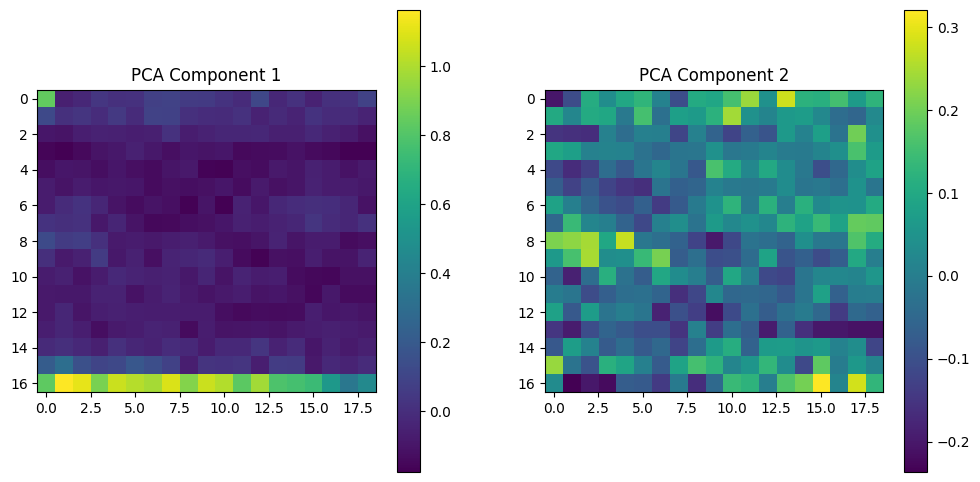

In [15]:
# Apply PCA to reduce dimensions for clustering (optional, but often helpful)
pca = PCA(n_components=100)
pca_result = pca.fit_transform(flattened_data)

pca_result_reshaped = pca_result.reshape(n_samples, n_features, 100)

# Visualize the PCA components
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(pca_result_reshaped[:, :, 0], cmap='viridis')
plt.colorbar()
plt.title("PCA Component 1")

plt.subplot(1, 2, 2)
plt.imshow(pca_result_reshaped[:, :, 1], cmap='viridis')
plt.colorbar()
plt.title("PCA Component 2")
#save_figure("R-T_Wheat_1stControl_1_PCA")

In [17]:
#save_figure("R-T_Wheat_1stControl_1_PCA")

In [19]:
#optics
t0=time.time()

min_samples = int((n_samples * n_features) / 5)  # Number of samples in a neighborhood for a point to be considered a core point

optics_new = OPTICS(min_samples=min_samples, max_eps=0.61, n_jobs=-1)
clusters_new = optics_new.fit(pca_result)

t1=time.time()
print(t1-t0)

n_samples, n_features, n_bands = new_spectral_data_3d.shape
new_spectral_data_2d = new_spectral_data_3d.reshape(n_samples*n_features,n_bands)
#np.savetxt("Optics_R-T_Wheat_1stControl_1.txt", new_spectral_data_2d)

cluster_labels_reshaped = clusters_new.labels_.reshape(n_samples,n_features)

0.43640708923339844


In [21]:
# Connected Components

image = cluster_labels_reshaped

num_labels, labels_im = cv2.connectedComponents((image == 0).astype(np.uint8))

# Determine the size of each component
component_sizes = np.bincount(labels_im.flatten())

largest_label = np.argmax(component_sizes[1:]) + 1

# Create the final image: keep only the largest component, set others to -1
final_image = image.copy()
final_image[(labels_im != largest_label) & (labels_im != 0)] = -1

[ 739  811  826  861  875  951  979  993 1048 1067 1081 1110 1150 1186
 1222 1245 1280 1303 1322 1348 1353 1372 1434 1490 1520 1583 1604 1625
 1640 1666 1684 1700 1727 1732 1739 1759 1779 1792]


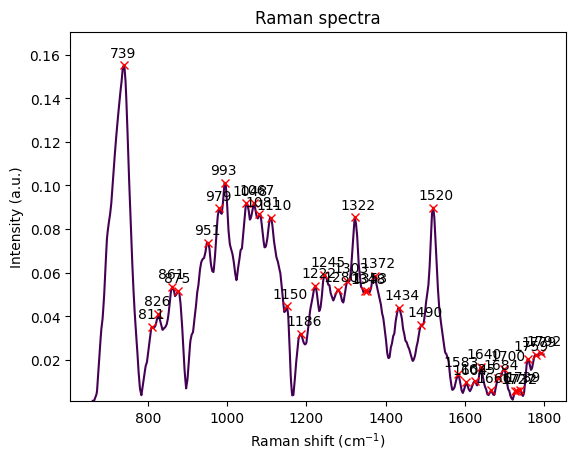

In [32]:
#Removing the vectors on metal Pixels

updated_spectral_data_3d = new_spectral_data_3d.copy()
print
for i in np.arange(np.count_nonzero(final_image)):
    updated_spectral_data_3d[np.where(final_image==-1)[0][i]][np.where(final_image==-1)[1][i]] = 0

y=np.zeros(1140)
for i in np.arange(row):
    for j in np.arange(column):
        for k in np.arange(1140):
            y[k] += updated_spectral_data_3d[i,j,k]
#new_spectral_axis[np.where(y==y.max())[0][0]]

spectral_data = {}

total_spec_np = y/(row*column)
total_spec=rp.Spectrum(y/(row*column),new_spectral_axis)

#total_spec=rp.Spectrum(y/1140,new_spectral_axis)
peaks = total_spec.peaks()[0] + 660
print(peaks)
spectral_data["spec_np"] = total_spec_np
spectral_data["spec_rp"] = total_spec #buradaki gereksizleri sil
spectral_data["peaks"] = peaks
rp.plot.peaks(total_spec)
#plt.plot(new_spectral_axis, total_spec_np, color="red")
#save_figure("R-T_Wheat_1stControl_1_Spectra")
#np.save("spectral_data_" + filename[:-4] + ".npy", spectral_data)
np.save("spectrums" + filename[:-4] + ".npy", new_spectral_data_3d)

plt.show()

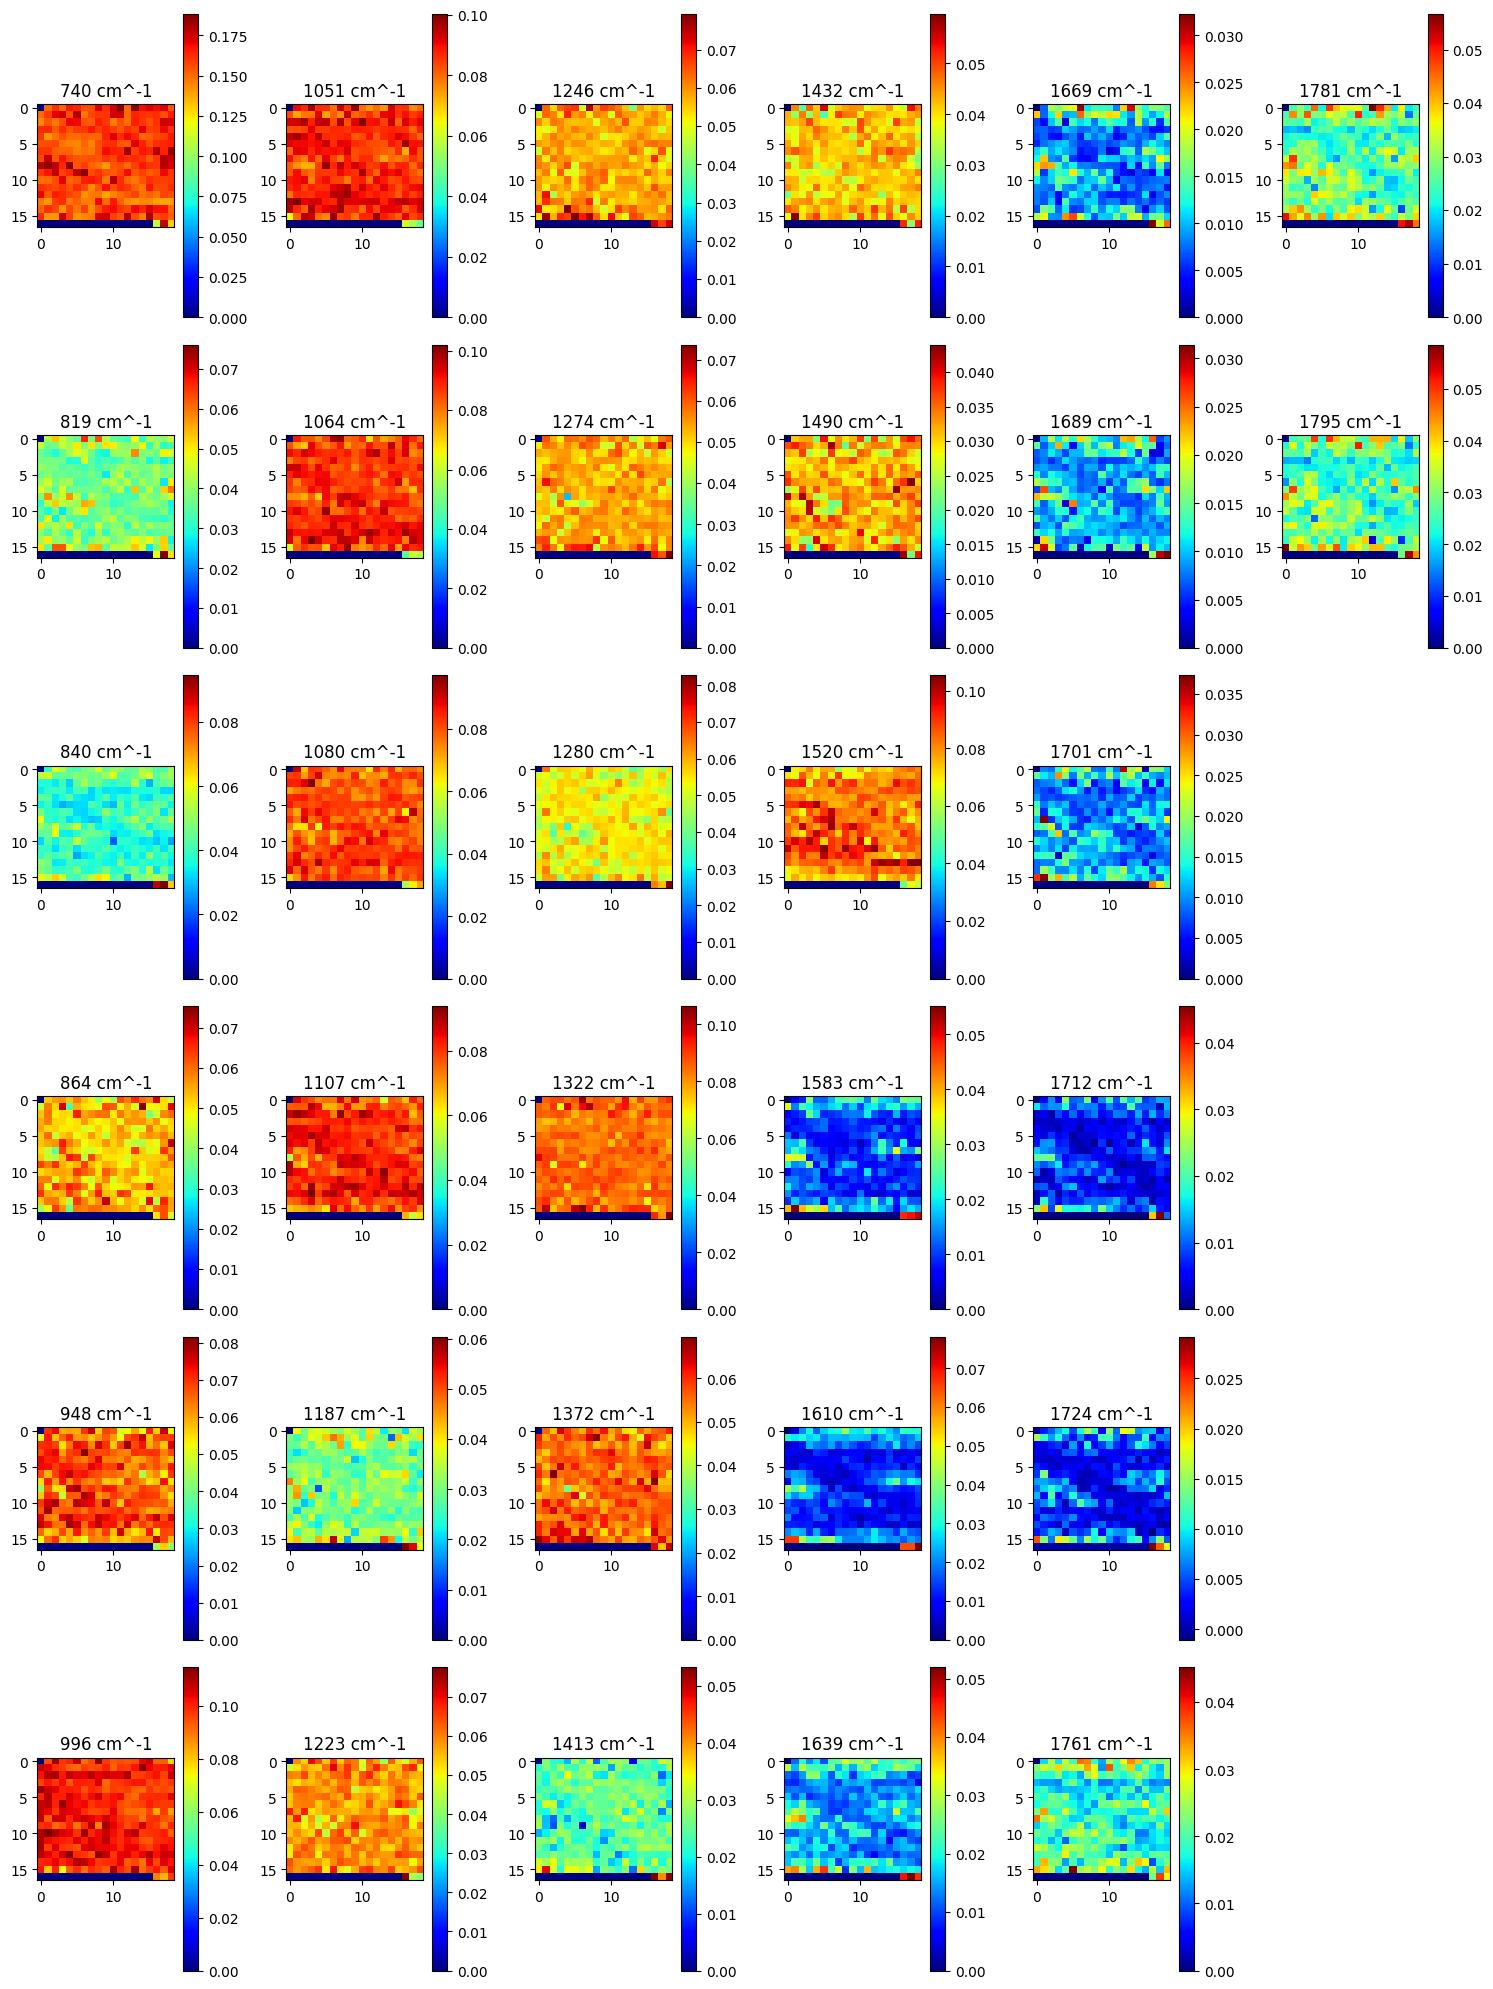

In [35]:
nmb_col = (total_spec.peaks()[0].shape[0])//6
fig, axes = plt.subplots(6, nmb_col+1 , figsize=(15, 20))
our_range = ((total_spec.peaks()[0].shape[0])//6)*6
remainder = total_spec.peaks()[0].shape[0]%6
peak_map = {}
for i in np.arange(total_spec.peaks()[0].shape[0]):
    if i < our_range:
        row = (i % 6)
        col = (i // 6)
    else:
        row = (i - our_range)
        col = nmb_col
    #  save peak maps as dictionary file
    peak_map[new_spectral_axis[total_spec.peaks()[0][i]]] = updated_spectral_data_3d[:,:,total_spec.peaks()[0][i]]
    
    im = axes[row, col].imshow(updated_spectral_data_3d[:,:,total_spec.peaks()[0][i]], cmap='jet')
    axes[row, col].title.set_text(str(new_spectral_axis[total_spec.peaks()[0][i]]) + ' cm^-1')
    fig.colorbar(im, ax=axes[row, col])

#  save peak maps as dictionary file
np.save("peakmap_data" + filename[:-4] + ".npy", peak_map)

for r in range(6):
    for c in range(nmb_col+1):
        if (r, c) not in [(i % 6, i // 6) for i in range(our_range)] and (r, c) not in [(i, nmb_col) for i in range(remainder)]:
            fig.delaxes(axes[r, c])

fig.tight_layout()
#save_figure("Map_R-T_Wheat_1stControl_1")  # Replace "my_figure_name" with your desired filename
plt.show()

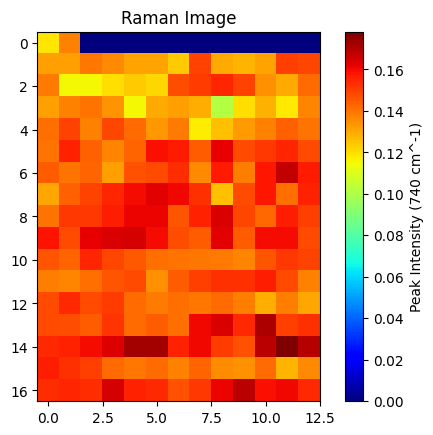

In [16]:
plt.imshow(updated_spectral_data_3d[:,:,np.where(y==y.max())[0][0]],cmap='jet')
plt.colorbar(label = "Peak Intensity (" +str(new_spectral_axis[np.where(y==y.max())[0][0]]) + " cm^-1)")
plt.title("Raman Image")
plt.show()

In [17]:
#Saving the resulting data as a 2D text file
updated_spectral_data_2d = updated_spectral_data_3d.reshape(n_samples*n_features,n_bands)

# Adjust the location with respect to your PC.
#np.savetxt(r"Results_R-T_Wheat_1stControl_1.txt", updated_spectral_data_2d)

In [18]:
#comparison